In [8]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

!pip install yolov4
!pip install opencv-python

In [9]:
!pip install scikit_image

In [10]:
!pip install numpy

In [11]:
!pip install tensorflow

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\maxi1\\anaconda3\\Lib\\site-packages\\~~mpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.




  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3


In [12]:
!pip install mediapipe

In [13]:
!pip uninstall opencv-python

^C


<h1>Start of code</h1>

In [1]:
import tensorflow as tf
from yolov4.tf import YOLOv4
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
from PIL import Image

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)
im = cv.imread("Offside_Images/0.jpg")
im.shape

(1440, 2560, 3)

In [3]:
im_height = im.shape[0]
im_width = im.shape[1]

In [4]:
def bgr2rgb(image):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

<h2>Detecting lines of pitch</h2>

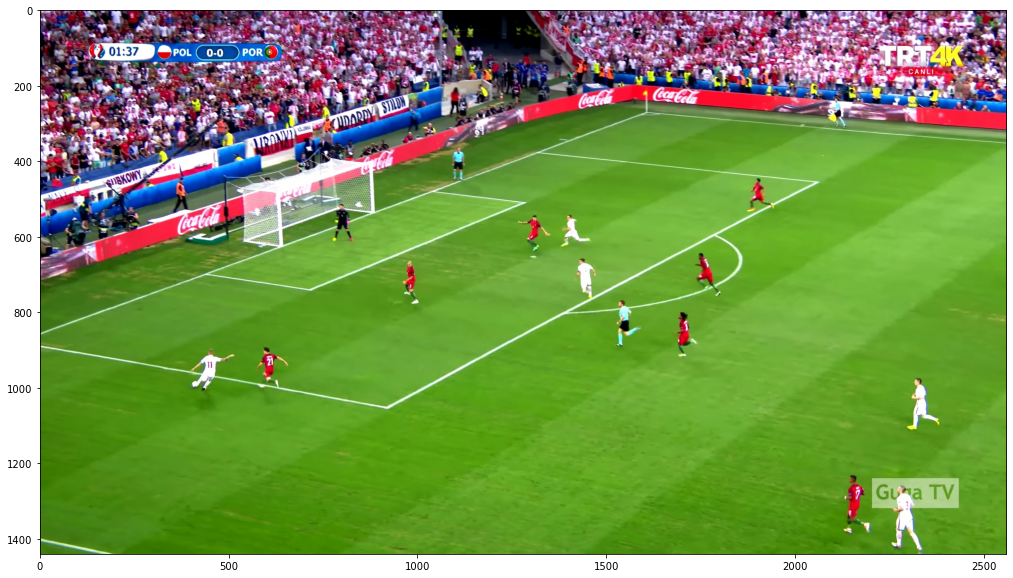

In [5]:
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))

<h3>Remove background from pitch</h3>

In [6]:
#check window contains enough green pixels - if not, 

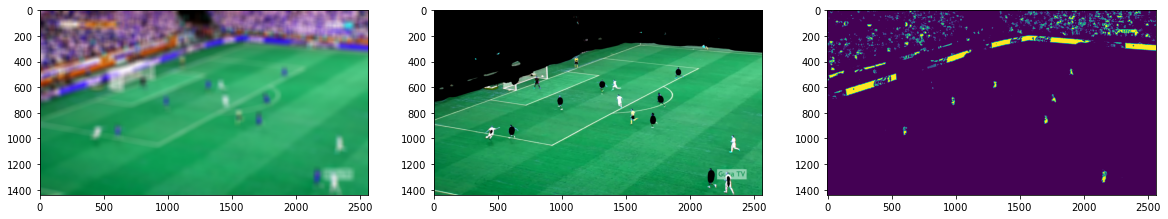

In [7]:
#applying green and white colour mask to image


blur = cv.GaussianBlur(im,(51,51),25)

#colour more separated in hsv space
hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
#green range
lower_green = np.array([30,30, 30])
upper_green = np.array([70, 255, 255])

#white range
sensitivity = 100
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])

green_mask = cv.inRange(hsv, lower_green, upper_green)
white_mask = cv.inRange(im, lower_white, upper_white)

final_mask = green_mask + white_mask
#final_mask = cv.dilate(final_mask, (7,7),iterations = 200)
#final_mask = cv.morphologyEx(final_mask, cv.MORPH_CLOSE, (7,7), iterations=200)

result1 = cv.bitwise_and(im, im, mask=green_mask)
result2 = cv.bitwise_and(im, im, mask=white_mask)

plt.subplot(1, 3, 1)
plt.imshow(blur, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(result1)
plt.subplot(1,3,3)
plt.imshow(white_mask)
plt.show()

#convert to hsv to gray
#res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
#res_gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)

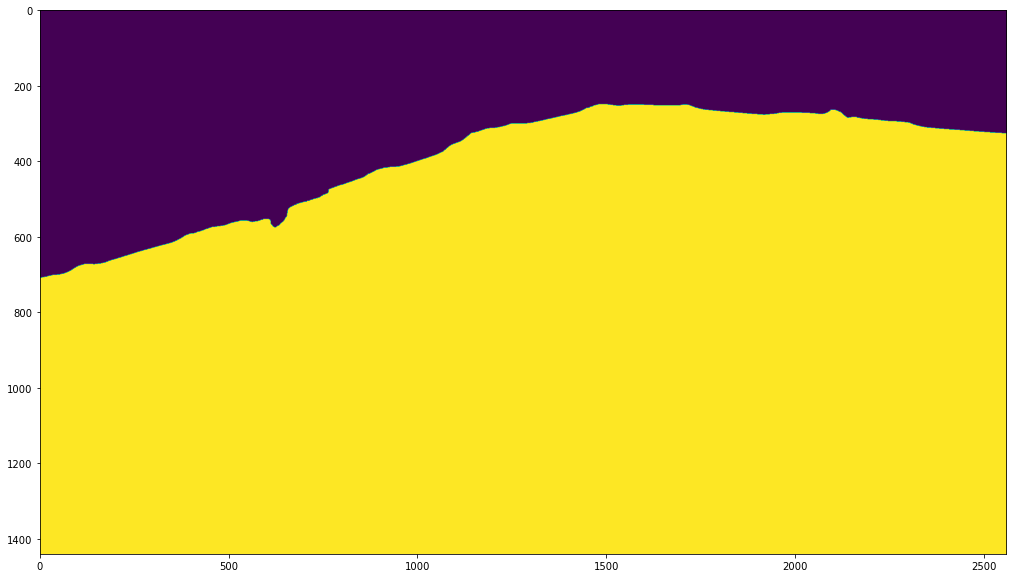

In [8]:
#use contour detection to extract the largest found contour
#use morphological operations on mask to remove noise

cont_im = im.copy()

contours, h = cv.findContours(green_mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
cv.drawContours(cont_im, contours , 1,(255, 0, 0), 2)
big_contour = max(contours, key=cv.contourArea)

mask = np.zeros((im_height, im_width), dtype=np.uint8)
cv.drawContours(mask, [big_contour], 0, (255,255,255), cv.FILLED)

#dilate - dont want to bind to the pitch to tightly as players are often at the edge
kernel = np.ones((7,7), 'uint8')
mask = cv.dilate(mask, kernel, iterations=2)
plt.imshow(mask)


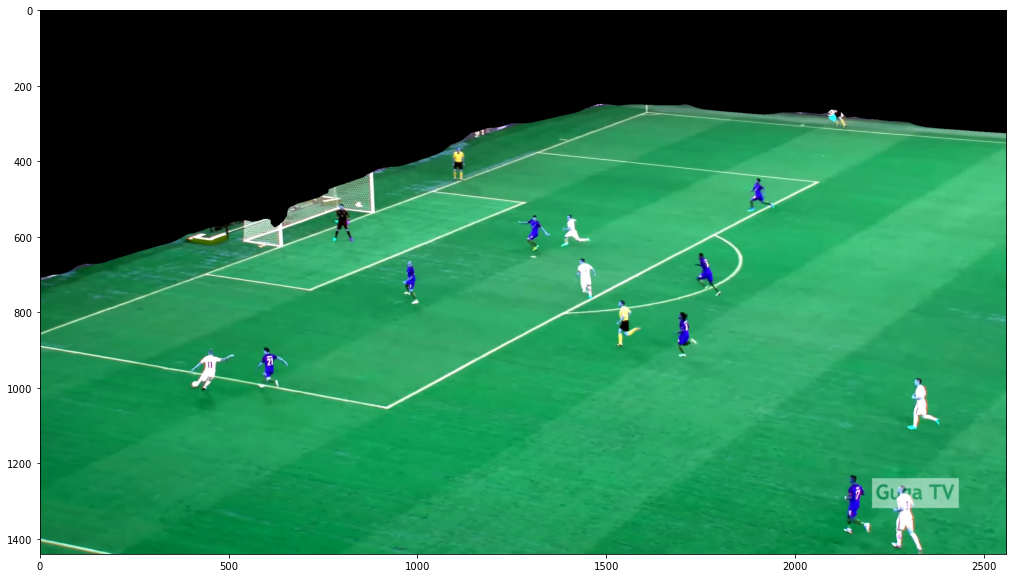

In [9]:
masked_im = cv.bitwise_and(im, im, mask=mask)
plt.imshow(masked_im)

<h3>Edge detection</h3>

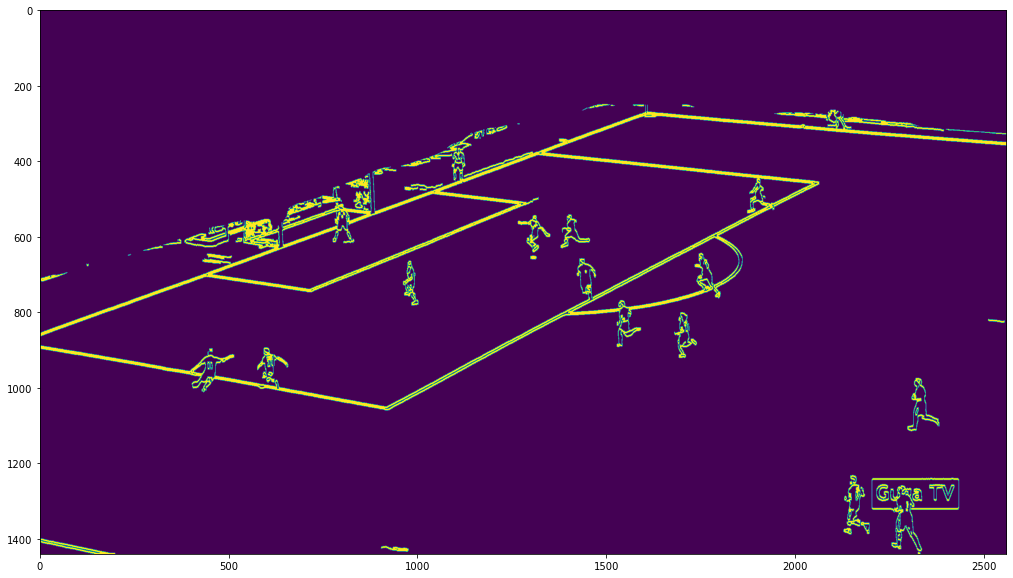

In [10]:
#masked_im = cv.bitwise_and(masked_im, masked_im, mask=white_mask)

gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
#gray = cv.equalizeHist(gray)
blur = cv.GaussianBlur(gray,(5,5),2)

#masked_im = cv.bitwise_and(gray, gray, mask=white_mask)
canny = cv.Canny(blur, 20, 80, apertureSize=3)
dilation = cv.dilate(canny, (5,5) ,iterations = 4)


masked_dil = cv.bitwise_and(dilation, dilation, mask=mask)
plt.imshow(masked_dil)

In [11]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=3.0):
    hxx, hyy, hxy = hessian_matrix(gray, sigma)
    i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])
    return i1, i2

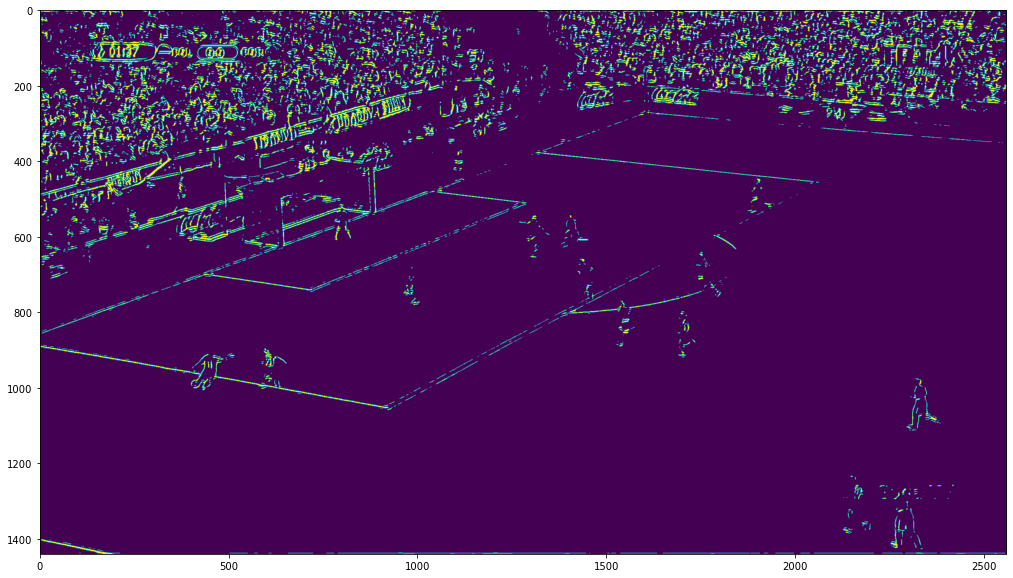

In [12]:
i1, i2 = detect_ridges(gray, 2)
_, thr_im = cv.threshold(src=i1, thresh=0.02, maxval=255, type=cv.THRESH_BINARY)
plt.imshow(thr_im)

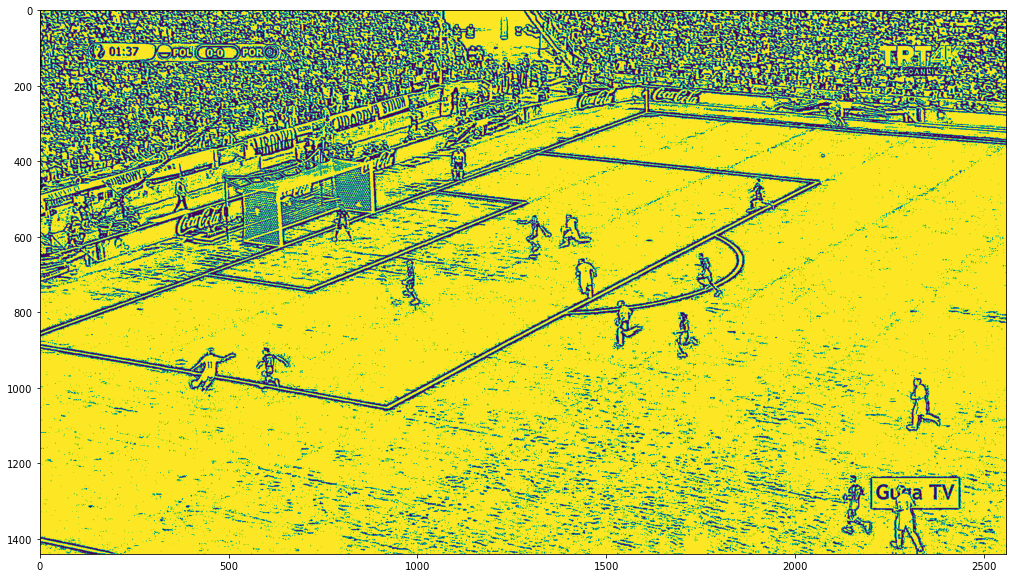

In [13]:
gray = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
thresh = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
plt.imshow(thresh)

<h3>Hough transform</h3>

In [57]:
def plot_lines(lines, line_image):

    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            print(lines[i])
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv.line(line_image, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
    
    plt.imshow(line_image)

(20, 1, 2)
(20, 1, 2)
[[809.          1.2217305]]
[[806.          1.2217305]]
[[1.3650000e+03 1.0821041e+00]]
[[880.          1.7453293]]
[[1.3590000e+03 1.0821041e+00]]
[[875.          1.7453293]]
[[133.          1.6580628]]
[[129.          1.6580628]]
[[1.3450000e+03 1.0995574e+00]]
[[1.3610000e+03 1.0821041e+00]]
[[243.          1.6755161]]
[[241.          1.6755161]]
[[239.          1.6755161]]
[[236.          1.6755161]]
[[169.          1.6406095]]
[[815.          1.2042772]]
[[957.          1.1868238]]
[[825.          1.2042772]]
[[953.          1.1868238]]
[[822.          1.2042772]]


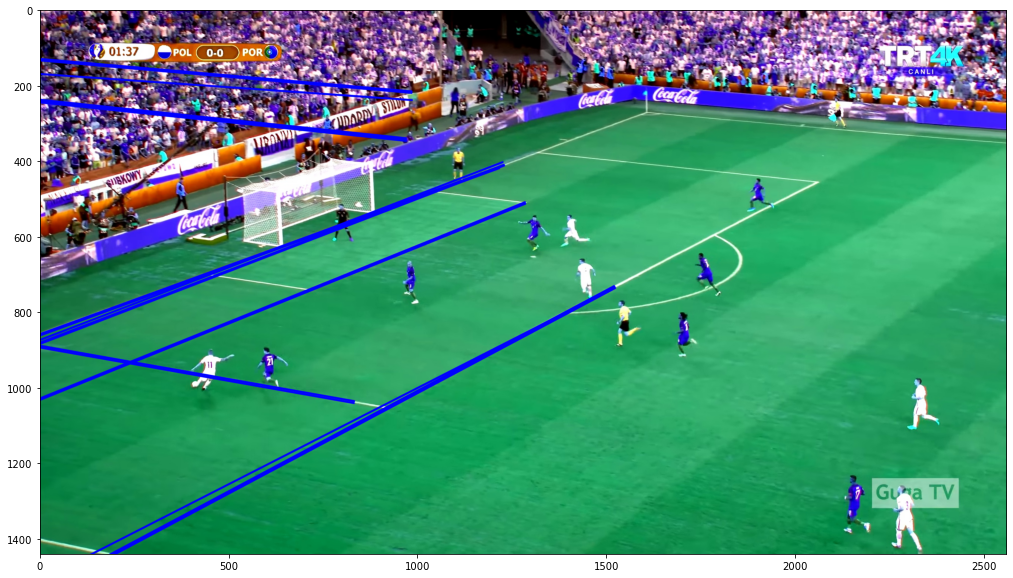

In [58]:
import math

#Hough transform and calculation to visualise lines back onto original image
line_image = im.copy()
line_edges = masked_dil.copy()
line_edges = cv.cvtColor(masked_dil, cv.COLOR_GRAY2BGR)

lines = cv.HoughLines(masked_dil, 1, np.pi / 180, 300)#, min_theta = 1, max_theta = 2)

lines = lines[:20]
print(lines.shape)
#lines = lines.reshape((1,-1,2))
print(lines.shape)


if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            print(lines[i])
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv.line(line_image, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
    
plt.imshow(line_image)

<h3>Seperate vertical and horizontal lines and find two most discriminating of each</h3>

In [59]:
print(lines.shape)

angles = []

for line in lines:
    l = line[0]
    angles.append([l[1]])
        

(20, 1, 2)


In [60]:
#split lines into vertical and horizontal lines
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters = 2)
preds = kmean.fit_predict(angles)

horizontal_lines = []
vertical_lines = []

for i in range(len(preds)):
    pred = preds[i]
    if pred == 0:
        horizontal_lines.append(lines[i])
    else:
        vertical_lines.append(lines[i])


In [61]:
#extract lines that are significantally different from each other (ordered by number of votes)

def extract_unique_lines(lines):

    unique_lines = lines.copy()
    length = len(unique_lines)

    i = 0
    while i < length:
        rho = unique_lines[i][0][0]
        theta = unique_lines[i][0][1] 

    
        j = 0
        while(j < length):
       
            if (unique_lines[j][0][0] != rho) | (unique_lines[j][0][1] != theta):
            
                if (rho - 40 <= unique_lines[j][0][0] <= rho + 40):
                
                    removed = unique_lines.pop(j)
                    length -= 1
                    j -= 1
            j += 1
    
        i += 1   
    return unique_lines

In [62]:
def two_lines(unique_lines):
    lines = [x[0] for x in unique_lines]
    ordered = sorted([(j,i) for (i,j) in lines])
    big_two = [ordered[0], ordered[-1]]
    two_lines = [np.array([[i,j]]) for (j,i) in big_two]
    
    return two_lines

<h3>Two best lines selected</h3>

[array([[880.       ,   1.7453293]], dtype=float32), array([[133.       ,   1.6580628]], dtype=float32), array([[243.       ,   1.6755161]], dtype=float32)]
[[133.          1.6580628]]
[[880.          1.7453293]]


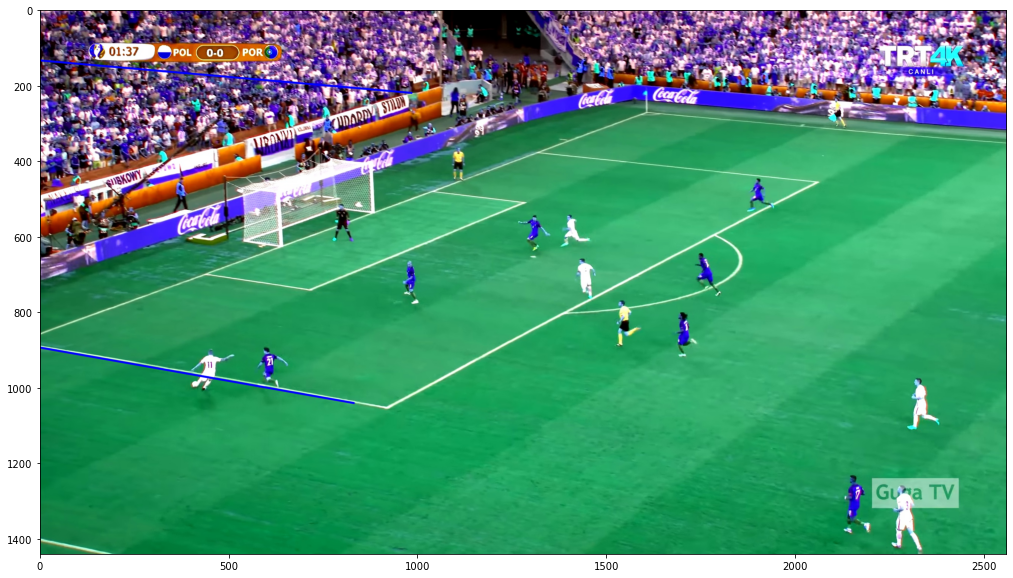

In [63]:
#now only one line produced per physical line on the pitch (each line has the highest threshold of its set)

line_image = im.copy()
unique_h_lines = extract_unique_lines(horizontal_lines)
print(unique_h_lines)
two_unqiue_h_lines = two_lines(unique_h_lines)
plot_lines(two_unqiue_h_lines, line_image)


[[1.3650000e+03 1.0821041e+00]]
[[809.          1.2217305]]


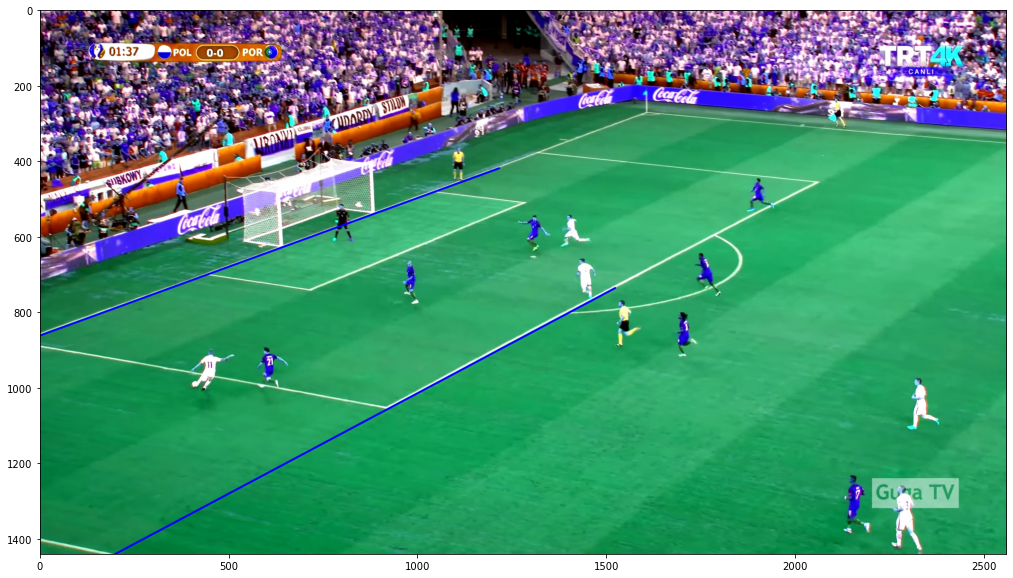

In [68]:
line_image = im.copy()
unique_v_lines = extract_unique_lines(vertical_lines)
two_unique_v_lines = two_lines(unique_v_lines)
plot_lines(two_unique_v_lines, line_image)

In [69]:
#find intersection point of the produced lines

def vanishing_point(two_lines):
    r1 = two_lines[0][0][0]
    theta1 = two_lines[0][0][1]
    
    r2 = two_lines[1][0][0]
    theta2 = two_lines[1][0][1]
    
    A = [[math.cos(theta1), math.sin(theta1)],
         [math.cos(theta2), math.sin(theta2)]]
    
    b = [r1, r2]
    
    result = np.linalg.solve(A, b)
    return result

In [71]:
vertical_vanishing_pt = vanishing_point(two_unique_v_lines)
print(vertical_vanishing_pt)

[4083.94769163 -625.51560486]


<h3>Probabilistic Hough Transform</h3>

[   0  861 1625  270]
[ 914 1059 2054  453]
[   0  857 1616  269]
[   0  860 1622  270]
[   0  891  930 1055]
[   0  895  925 1058]
[ 706  745 1319  497]
[   2  888  935 1052]
[   0  859 1620  270]
[1692  276 2253  334]
[   0  856 1613  269]
[   0  863 1517  310]
[1387  810 2059  453]
[ 786  569 1610  269]
[423 624 882 448]
[1464  770 2060  454]
[ 193  794 1220  420]
[   0  890  932 1054]
[447 627 786 490]
[ 533  989  924 1058]
[ 906 1056 1680  645]
[1225  407 1608  268]
[2199  301 2559  327]
[   0  888  933 1053]
[2015  303 2491  353]
[   0  893  927 1056]
[538 616 884 497]
[1603  266 1950  308]
[539 613 884 488]
[1962  300 2427  348]
[ 934  425 1236  310]
[1916  296 2389  345]
[660 526 964 410]
[1944  274 2304  299]
[ 915 1059 2055  453]
[ 660  529 1002  398]
[1837  289 2340  341]
[1749  281 2290  337]
[540 616 884 498]
[420 624 882 447]
[ 699  744 1307  499]
[1951  275 2307  300]
[2081  292 2460  319]
[ 907 1057 1807  579]
[2250  306 2559  328]
[2108  312 2507  354]
[452 627 786 492

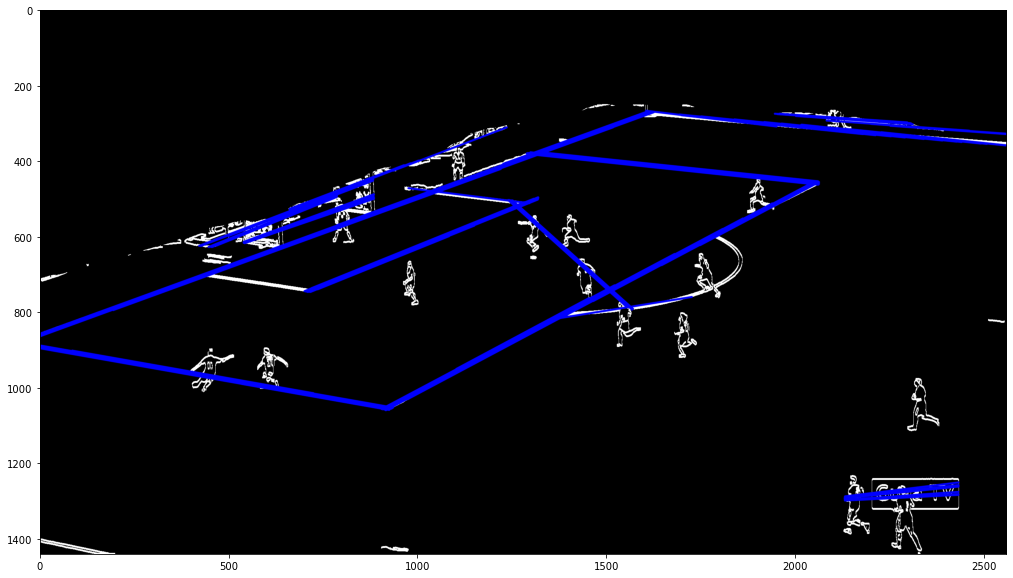

In [24]:
#use probabilistic Hough transform to detect pitch lines

line_image = im.copy()
line_edges = masked_dil.copy()
line_edges = cv.cvtColor(masked_dil, cv.COLOR_GRAY2BGR)



lines = cv.HoughLinesP(masked_dil, rho=1, theta=np.pi / 180, threshold=10, minLineLength=300, maxLineGap=50)

if lines is not None:
    for i in range(0, len(lines)):
        l = lines[i][0]
        print(l)
        cv.line(line_edges, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
    

        
plt.imshow(line_edges)

In [25]:
line_image = im.copy()
line_edges = masked_dil.copy()
line_edges = cv.cvtColor(masked_dil, cv.COLOR_GRAY2BGR)

print(horizontal_lines)

if lines is not None:
    for i in range(0, len(horizontal_lines)):
        l = horizontal_lines[i][0]
        print(l)
        cv.line(line_edges, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
    

        
plt.imshow(line_edges)

[array([[880.       ,   1.7453293]], dtype=float32), array([[875.       ,   1.7453293]], dtype=float32), array([[133.       ,   1.6580628]], dtype=float32), array([[129.       ,   1.6580628]], dtype=float32), array([[243.       ,   1.6755161]], dtype=float32), array([[241.       ,   1.6755161]], dtype=float32), array([[239.       ,   1.6755161]], dtype=float32), array([[236.       ,   1.6755161]], dtype=float32), array([[169.       ,   1.6406095]], dtype=float32)]
[880.          1.7453293]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [27]:
#calculate slopes of detected lines


vertical_lines = []
vertical_slopes = []
horizontal_lines = []
horizontal_slopes = []


height = im.shape[0]

count = 0
for line in lines:
    l = line[0]
    X = float(l[2] - l[0])
    Y = float(l[1] - l[3])
    slope = Y / X
    
    if slope < 0:
        horizontal_lines.append(line)
        horizontal_slopes.append(slope)
    else:
        vertical_lines.append(line)
        vertical_slopes.append(slope)
    count+=1



In [28]:
#calculate length of lines
horizontal_lengths = []

for line in horizontal_lines:
    l = line[0]
    X = abs(l[2] - l[0])
    Y = abs(l[1] -  l[3])
    length = math.sqrt(X**2 + Y**2)
    horizontal_lengths.append(length)
    print(length)
print(horizontal_lengths)

944.3495115686776
939.2518299157048
947.3040694518313
563.9902481426429
946.3191850533307
397.0415595375376
360.93766774887877
947.4777042231653
478.6188462649585
941.2215467146935
349.53254497972
467.4708547064726
475.53128183117457
360.86701151532264
505.6807293144559
543.8906140024849
356.87672941787616
379.9605242653505
309.78218154051405
401.2044366653988
334.8342873721268
779.3259908408035
768.1770629223447
776.2377213199575
753.1546985845604
749.0720926586439
769.1716323422231
649.8992229569135
311.77716401301745
433.3405127610388
340.77705321808276
429.26099287030496
771.2651943397939
430.5159695063587
431.9282347798069
422.7114855312072
403.6087214122113
484.5864216009359
765.1934395955052
324.4749605131342
928.0716567162258
420.3094098399416
429.36464689119435
[944.3495115686776, 939.2518299157048, 947.3040694518313, 563.9902481426429, 946.3191850533307, 397.0415595375376, 360.93766774887877, 947.4777042231653, 478.6188462649585, 941.2215467146935, 349.53254497972, 467.470854

In [29]:
result_list = [(i,j) for (_,i,j) in sorted(zip(horizontal_lengths, horizontal_lines, horizontal_slopes))]

print(result_list)

[(array([[2250,  306, 2559,  328]], dtype=int32), -0.07119741100323625), (array([[2000,  280, 2311,  302]], dtype=int32), -0.0707395498392283), (array([[ 974,  471, 1296,  511]], dtype=int32), -0.12422360248447205), (array([[2226,  323, 2559,  358]], dtype=int32), -0.10510510510510511), (array([[1956,  274, 2296,  297]], dtype=int32), -0.06764705882352941), (array([[1603,  266, 1950,  308]], dtype=int32), -0.12103746397694524), (array([[1951,  275, 2307,  300]], dtype=int32), -0.0702247191011236), (array([[1944,  274, 2304,  299]], dtype=int32), -0.06944444444444445), (array([[2199,  301, 2559,  327]], dtype=int32), -0.07222222222222222), (array([[2081,  292, 2460,  319]], dtype=int32), -0.0712401055408971), (array([[ 533,  989,  924, 1058]], dtype=int32), -0.17647058823529413), (array([[2108,  312, 2507,  354]], dtype=int32), -0.10526315789473684), (array([[1241,  502, 1541,  772]], dtype=int32), -0.9), (array([[1794,  287, 2212,  331]], dtype=int32), -0.10526315789473684), (array([[1

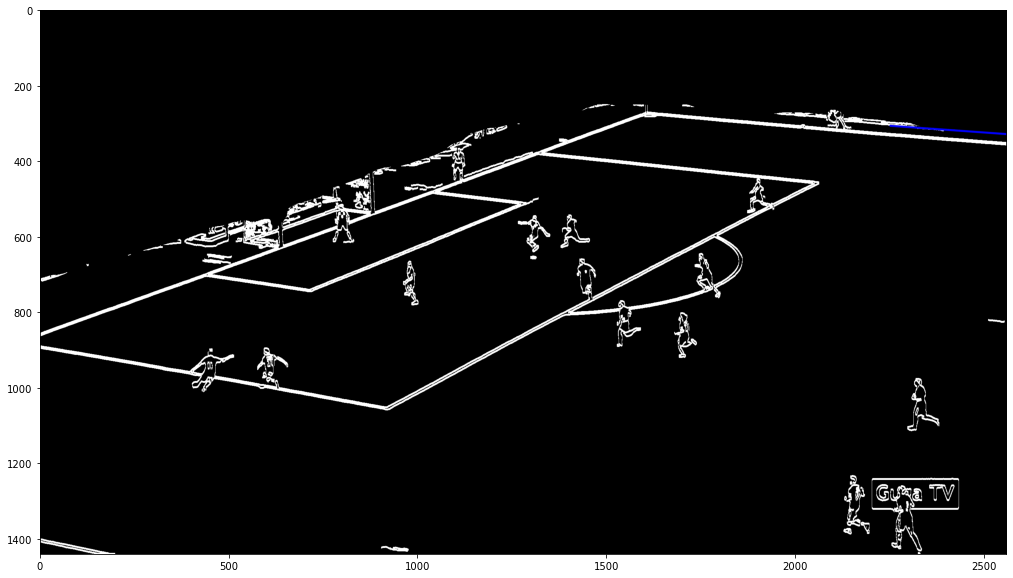

In [30]:
line_image = im.copy()
line_edges = masked_dil.copy()
line_edges = cv.cvtColor(masked_dil, cv.COLOR_GRAY2BGR)

l = result_list[0][0][0]

cv.line(line_edges, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
plt.imshow(line_edges)

<h3>Player detection</h3>

In [31]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils

In [32]:
#Load yolo with default config and weights

yolo = YOLOv4()

yolo.config.parse_names("coco.names")
yolo.config.parse_cfg("yolov4.cfg")

yolo.make_model()
yolo.load_weights("yolov4.weights", weights_type="yolo")
yolo.summary(summary_type="yolo")
yolo.summary()


batch: 32
index layer No. filters  size/strd(dil)   input_shape         output_shape    1e9 flops
   0  convo_0      32      3 x 3 / 1      512 x 512 x   3 ->  512 x 512 x  32   0.453
   1  convo_1      64      3 x 3 / 2      512 x 512 x  32 ->  256 x 256 x  64   2.416
   2  convo_2      64      1 x 1 / 1      256 x 256 x  64 ->  256 x 256 x  64   0.537
   3  route_0       1,                                    ->  256 x 256 x  64
   4  convo_3      64      1 x 1 / 1      256 x 256 x  64 ->  256 x 256 x  64   0.537
   5  convo_4      32      1 x 1 / 1      256 x 256 x  64 ->  256 x 256 x  32   0.268
   6  convo_5      64      3 x 3 / 1      256 x 256 x  32 ->  256 x 256 x  64   2.416
   7  short_0       4,  6,                                ->  256 x 256 x  64   0.004
   8  convo_6      64      1 x 1 / 1      256 x 256 x  64 ->  256 x 256 x  64   0.537
   9  route_1       8,  2,                                ->  256 x 256 x 128
  10  convo_7      64      1 x 1 / 1      256 x 256 x 128 

In [33]:
boxes = yolo.predict(masked_im, 0.4)

In [34]:
player_boxes = []

for box in boxes:
    if box[4] == 0:
        player_boxes.append(box)
        
print(player_boxes)

[array([0.89697117, 0.9367072 , 0.0348772 , 0.12157261, 0.        ,
       0.9000948 ], dtype=float32), array([0.17731576, 0.6643131 , 0.04580165, 0.07881418, 0.        ,
       0.8651411 ], dtype=float32), array([0.9123181 , 0.7241267 , 0.02634576, 0.09867964, 0.        ,
       0.8206972 ], dtype=float32), array([0.56475115, 0.4912144 , 0.01854518, 0.07265627, 0.        ,
       0.7967236 ], dtype=float32), array([0.23868524, 0.6560838 , 0.02863647, 0.0746775 , 0.        ,
       0.7951913 ], dtype=float32), array([0.43231943, 0.28288066, 0.0154464 , 0.06555492, 0.        ,
       0.74060386], dtype=float32), array([0.60465515, 0.5764458 , 0.01597914, 0.08505657, 0.        ,
       0.7299048 ], dtype=float32), array([0.3140182 , 0.39315858, 0.02308206, 0.06949793, 0.        ,
       0.7211383 ], dtype=float32), array([0.7420279 , 0.33731687, 0.01824571, 0.06658667, 0.        ,
       0.6670548 ], dtype=float32), array([0.6673524 , 0.59325004, 0.01644753, 0.07928262, 0.        ,
     

In [35]:
pred_im = yolo.draw_bboxes(im, player_boxes)

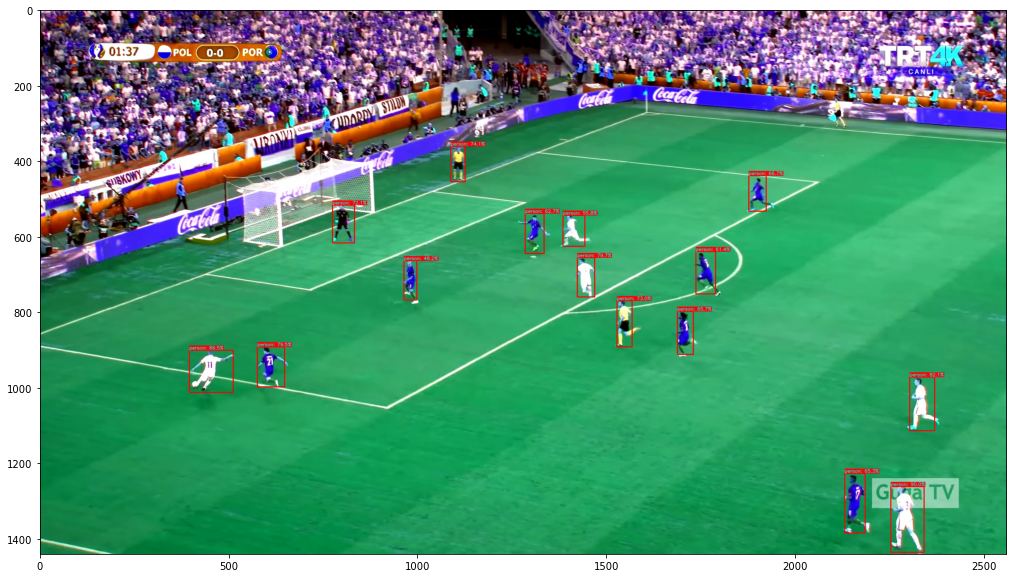

In [36]:
plt.imshow(pred_im)

<h3>Pose estimation</h3>

In [37]:
player_ims = []
lgr_player_ims = []

for x, y, x_length, y_length, id, _ in boxes[0:]:
    if id == 0:
    
        x = int(x * im_width)
        y = int(y * im_height)
    
        x_length = int((x_length * im_width) / 2) + 5
        y_length = int((y_length * im_height) / 2) + 5

        player_im = im[y - y_length : y + y_length , x - x_length: x + x_length]
        lgr_player_im = im[y - (y_length + 20)  : y + (y_length + 20) , x - (x_length + 20): x + (x_length + 20)]
        
        player_ims.append(player_im)
        lgr_player_ims.append(lgr_player_im)
    

In [38]:
#initilaising BlazePose with the MediaPipe library

mpPose = mp.solutions.pose
pose = mpPose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
mpDraw = mp.solutions.drawing_utils

In [39]:
pose.pose_landmarks??

Object `pose.pose_landmarks` not found.


('self', 'image', 'results', 'landmark')


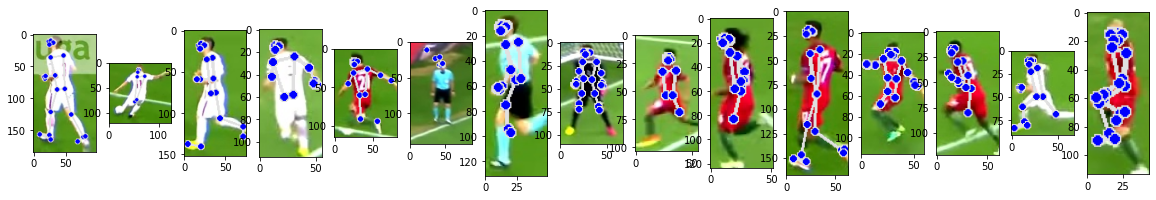

In [40]:
#for each person detected- estimate their pose. If pose not detected then make search window slightly larger and try again
player_joints = []
player_im_sizes = []

fig, axs = plt.subplots(1, len(player_ims))
axs = axs.ravel()
print(pose.process.__code__.co_varnames)
for i in range(0, len(player_ims)):
    size = 0
    playerRGB = cv.cvtColor(player_ims[i], cv.COLOR_BGR2RGB)
    results = pose.process(playerRGB)
    
    joints = []
    if results.pose_landmarks != None:    
        for j in range(0, 32):
            if j not in [15, 16, 17, 18, 19, 20, 21, 22]:
                    joints.append(results.pose_landmarks.landmark[j])
    
    
    if results.pose_landmarks == None:
        size = 1
        playerRGB = cv.cvtColor(lgr_player_ims[i], cv.COLOR_BGR2RGB)
        results = pose.process(playerRGB)
        joints = []
        
        if results.pose_landmarks != None:
            for j in range(0, 32):
                if j not in [15, 16, 17, 18, 19, 20, 21, 22]:
                    joints.append(results.pose_landmarks.landmark[j])
                    
    player_joints.append(joints)
    player_im_sizes.append(size)
    mpDraw.draw_landmarks(playerRGB, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
    axs[i].imshow(playerRGB)


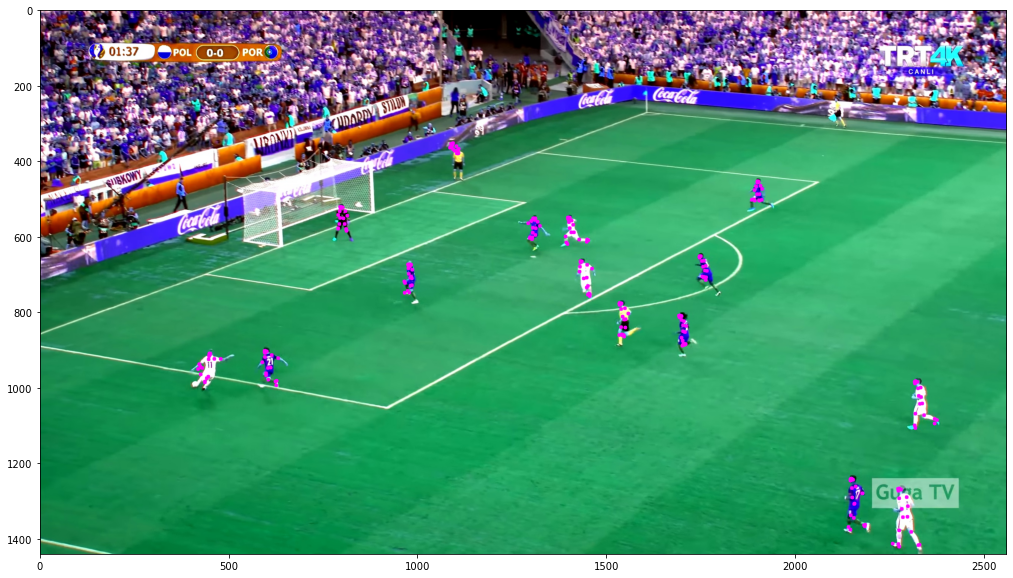

In [81]:
#obtain x, y coordinate of joint locations from pose estimations of individual images and plot back onto the original image
norm_player_joints = []

pose_im = im.copy()

unwanted_joints = [13,14,15,16,17,18,19,20,21,22]

for i in range(0, len(player_boxes)):
    landmarks = player_joints[i]
    size = player_im_sizes[i]

    x, y, x_length, y_length, id, _ = player_boxes[i]
    
    x = int(x * im_width)
    y = int(y * im_height)
    
    x_length = int((x_length * im_width)/2) + 5
    y_length = int((y_length * im_height)/2) + 5
    
    if player_im_sizes[i] == 1:
        x_length += 20
    
    x1 = x - x_length
    x2 = x + x_length
    
    y1 = y - y_length
    y2 = y + y_length
    
    for j in range(0, len(landmarks)):
        joints = []
        #if j not in unwanted_joints:
        lmrk = landmarks[j]
        
        l_x = lmrk.x
        l_y = lmrk.y
        
        im_x = int(x1 + l_x * 2 * x_length)
        im_y = int(y1 + l_y * 2 * y_length)
        joints.append((im_x, im_y))
        
        cv.circle(pose_im, (im_x, im_y), 5, (255,0,255), -1)
    norm_player_joints.append(joints)
plt.imshow(pose_im)

<h3>Team Classification</h3>

In [42]:
#use predefined color to detect ratio of pixels of color to size of player image
import webcolors



def identify_team(hue1, hue2, sat1, sat2, val1, val2):
    fig, axs = plt.subplots(1, len(player_ims))
    axs = axs.ravel()

    team_players = []

    for ax, player_im, i in zip(axs, player_ims, range(0, len(player_ims))):

        hsv = cv.cvtColor(player_im, cv.COLOR_BGR2HSV)
        
        if hue1 == 0:
            team_lower_1 = np.array([170,150, 150])
            team_upper_1 = np.array([180, 255, 255])

            team_lower_2 = np.array([0,150, 100])
            team_upper_2 = np.array([10,255, 255])

            team_mask_1 = cv.inRange(hsv, team_lower_1, team_upper_1)
            team_mask_2 = cv.inRange(hsv, team_lower_2, team_upper_2)

            team_mask = cv.bitwise_or(team_mask_1, team_mask_2)
            
        else:
            
            team_lower = np.array([hue1, sat1, val1])
            team_upper = np.array([hue2, sat2, val2])
            team_mask = cv.inRange(hsv, team_lower, team_upper)
            
        team_im = cv.bitwise_and(player_im, player_im, mask=team_mask)
    
        contours, h = cv.findContours(team_mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    
    
        area_cont = 0
        area_im = float(player_im.shape[0] * player_im.shape[1])
        mask = np.zeros((player_im.shape[0], player_im.shape[1]), dtype=np.uint8)
    
        if contours != ():
            big_contour = max(contours, key=cv.contourArea)
            cv.drawContours(team_im, [big_contour], 0, (255,255,255), cv.FILLED)
            area_cont = cv.contourArea(big_contour)
            cv.drawContours(mask, [big_contour], 0, (255,255,255), cv.FILLED)
        
            color_ratio = area_cont / area_im
            print(area_cont, area_im, color_ratio)
            thresh = 0.03
            if color_ratio > thresh:
                team_players.append(i)
        

        ax.imshow(mask)
    return team_players

1.0 6384.0 0.00015664160401002505
741.0 9512.0 0.07790159798149705
1.0 6600.0 0.00015151515151515152
15.0 7480.0 0.002005347593582888
675.0 5824.0 0.11589972527472528
1074.0 6448.0 0.16656327543424318
1502.0 10752.0 0.13969494047619047
861.5 6960.0 0.1237787356321839
926.0 7564.0 0.12242199894235854
771.0 5016.0 0.15370813397129188
2814.5 18032.0 0.15608362910381543
2175.0 15372.0 0.1414910226385636
2114.0 11552.0 0.18299861495844874
1542.5 6384.0 0.24161967418546365
45.0 9512.0 0.004730866274179983
0.0 4992.0 0.0
16.0 6600.0 0.0024242424242424242
111.0 7480.0 0.014839572192513369
7.0 5824.0 0.001201923076923077
18.0 6448.0 0.002791563275434243
13.0 10752.0 0.001209077380952381
1.5 6960.0 0.00021551724137931034
17.0 7564.0 0.0022474881015335803
906.0 6256.0 0.14482097186700768
9.5 5016.0 0.001893939393939394


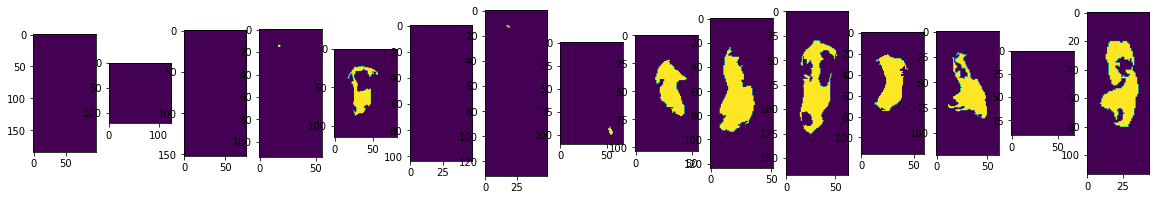

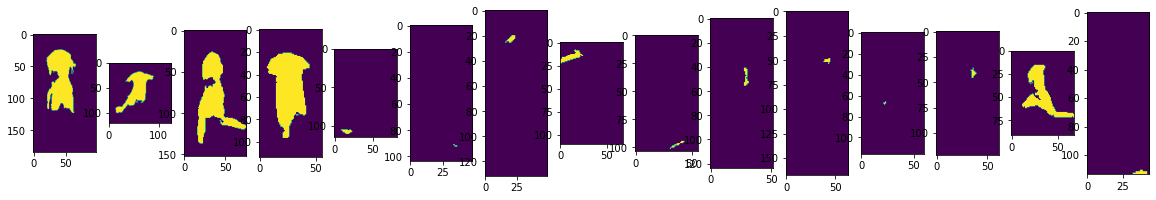

In [43]:
teams = [identify_team(0,0, 100, 255, 100, 255) , identify_team(20, 180, 0, 30, 200, 255)]

[[325899.]
 [714970.]
 [922223.]
 [565219.]
 [332643.]
 [119086.]
 [ 93996.]
 [ 84189.]
 [ 83568.]
 [ 73081.]
 [ 58505.]
 [ 50763.]
 [ 45151.]
 [ 39861.]
 [ 37876.]
 [139370.]]


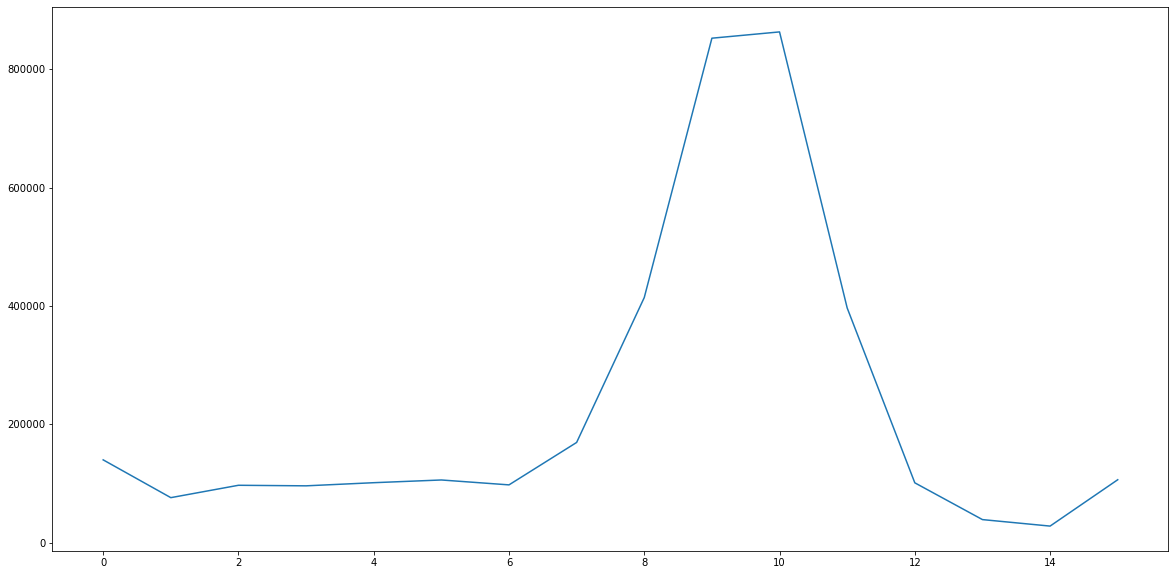

In [44]:
hist1 = cv.calcHist([im],[0],None,[16],[0,256])
hist2 = cv.calcHist([im],[1],None,[16],[0,256])
hist3 = cv.calcHist([im],[2],None,[16],[0,256])
plt.plot(hist2)


print(hist1)

In [45]:
#compute average R, G and B values

def average_colours(image):

    avg_cols = np.average(image, axis=(0,1))
    avg_cols / 255
    return avg_cols

In [46]:
def player_color_hist(ims):
    player_hists = []
    for player_im in ims:
        
        num_pixels = player_im.shape[0] * player_im.shape[1] 
        hist1 = cv.calcHist([player_im],[0],None,[16],[0,256]).ravel() / num_pixels
        hist2 = cv.calcHist([player_im],[1],None,[16],[0,256]).ravel() / num_pixels
        hist3 = cv.calcHist([player_im],[2],None,[16],[0,256]).ravel() / num_pixels
        player_hist = np.concatenate([hist1, hist2, hist3])
        #print(player_hist)
        player_hists.append(player_hist)
    return player_hists

In [47]:
player_colors = player_color_hist(player_ims)
print(player_colors)

[array([1.96872223e-02, 2.33362913e-01, 1.46905497e-01, 3.93744446e-02,
       2.19609588e-02, 1.92990247e-02, 1.95763092e-02, 2.55102050e-02,
       9.81588289e-02, 9.12821665e-02, 1.83562562e-02, 1.73580293e-02,
       1.70807447e-02, 1.60825197e-02, 2.07963623e-02, 1.95208520e-01,
       5.54569669e-05, 1.10913934e-04, 4.99112706e-04, 9.42768413e-04,
       1.77462294e-03, 4.04835865e-03, 6.48846477e-03, 2.14063879e-02,
       1.38309672e-01, 3.26696992e-01, 3.88753340e-02, 2.48447210e-02,
       6.28327429e-02, 1.48846492e-01, 2.19055004e-02, 2.02362463e-01,
       0.00000000e+00, 1.10913934e-04, 6.10026647e-04, 3.38287489e-03,
       8.51264447e-02, 2.93589175e-01, 8.85647759e-02, 2.47338060e-02,
       1.88553687e-02, 2.01863348e-02, 7.17058554e-02, 1.20452531e-01,
       1.55834071e-02, 1.51952086e-02, 1.81344282e-02, 2.23768860e-01],
      dtype=float32), array([0.18410096, 0.41933385, 0.06193078, 0.03532397, 0.02413479,
       0.02010148, 0.01769451, 0.01587302, 0.01541764, 0.

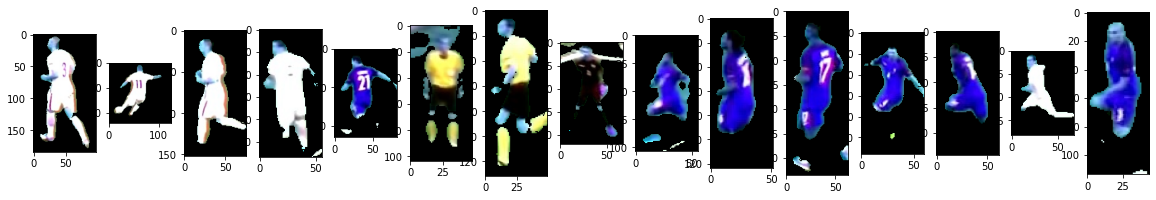

In [48]:
fig, axs = plt.subplots(1, len(player_ims))
axs = axs.ravel()

for player_im, ax in zip(player_ims, axs):
    
    hsv = cv.cvtColor(player_im, cv.COLOR_BGR2HSV)
    green_player_mask = cv.inRange(hsv, lower_green, upper_green)
    green_player_mask = 255 - green_player_mask
    res = cv.bitwise_and(player_im, player_im, mask=green_player_mask)
    
    ax.imshow(res)

In [49]:
print(player_colors)

[array([1.96872223e-02, 2.33362913e-01, 1.46905497e-01, 3.93744446e-02,
       2.19609588e-02, 1.92990247e-02, 1.95763092e-02, 2.55102050e-02,
       9.81588289e-02, 9.12821665e-02, 1.83562562e-02, 1.73580293e-02,
       1.70807447e-02, 1.60825197e-02, 2.07963623e-02, 1.95208520e-01,
       5.54569669e-05, 1.10913934e-04, 4.99112706e-04, 9.42768413e-04,
       1.77462294e-03, 4.04835865e-03, 6.48846477e-03, 2.14063879e-02,
       1.38309672e-01, 3.26696992e-01, 3.88753340e-02, 2.48447210e-02,
       6.28327429e-02, 1.48846492e-01, 2.19055004e-02, 2.02362463e-01,
       0.00000000e+00, 1.10913934e-04, 6.10026647e-04, 3.38287489e-03,
       8.51264447e-02, 2.93589175e-01, 8.85647759e-02, 2.47338060e-02,
       1.88553687e-02, 2.01863348e-02, 7.17058554e-02, 1.20452531e-01,
       1.55834071e-02, 1.51952086e-02, 1.81344282e-02, 2.23768860e-01],
      dtype=float32), array([0.18410096, 0.41933385, 0.06193078, 0.03532397, 0.02413479,
       0.02010148, 0.01769451, 0.01587302, 0.01541764, 0.

In [50]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.6, min_samples=1)
dbs.fit_predict(player_color_hist(player_ims))

array([0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], dtype=int64)

<h2>Offside algorithm</h2>

In [72]:
print(vertical_vanishing_pt)

[4083.94769163 -625.51560486]


In [91]:
#set the value of the defending team

def_team = 0


In [94]:
#use the vanishing point to calculate the furthest back defender/forward attacker


def get_furthest_player(team_id):
    vpt = vertical_vanishing_pt
    biggest_angle = 0
    last_def = -1
    coord = (0,0)
    
    for i in teams[team_id]:
       
        joints = norm_player_joints[i]
        for joint in joints:
            pt1 = [joint[0] , joint[1]]
            pt2 = [vpt[0], joint[1]]
            adj = math.dist(vpt, pt1)
            opp = math.dist(pt1, pt2)
            angle = math.atan(opp/adj)
            
            if angle > biggest_angle:
                biggest_angle = angle
                last_def = i
                coord = (joint[0], joint[1])
            
    
    return angle, last_def, coord

In [99]:
defend = get_furthest_player(0)

In [100]:
attack = get_furthest_player(1)

In [102]:
def offside_call(def_team, atck_team):
    offside = False
    
    if def_team < atck_team:
        offside = True
        
    return offside    

In [103]:
offside_call(defend, attack)

False

In [ ]:
!pip install --upgrade mxnet --user

In [ ]:
!pip install --upgrade gluoncv

In [ ]:
!pip install --upgrade mxnet


In [ ]:
import mxnet

In [ ]:
import mxnet
from gluoncv import model_zoo, data, utils